In [1]:
# !pip install matplotlib
# !pip install gurobipy
# !pip install torch_geometric

In [2]:
# !pip install scikit-learn

In [3]:
import gurobipy as gp
from gurobipy import GRB
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader  # Corrected import
from torch_geometric.nn import MessagePassing
from torch_geometric.nn import global_mean_pool  # For pooling in the decoder
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import random
import matplotlib.pyplot as plt  # For plotting losses

In [4]:
from parse_QP import my_callback

In [142]:
# Read the problem
number = "0031"
grb_model = gp.read(f"QPLIB_{number}.lp")

# Solution storage
grb_model._feasible_solutions = []
grb_model._relaxation_solutions = []
grb_model.setParam("MIPGap", 0.01)
#model.setParam("NodeLimit", 100)  # Explore a limited number of nodes

# Optimize
grb_model.optimize(my_callback)

Read LP format model from file QPLIB_0031.lp
Reading time = 0.00 seconds
obj: 32 rows, 60 columns, 120 nonzeros
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (linux64 - "Ubuntu 22.04.5 LTS")

CPU model: AMD EPYC 74F3 24-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 48 physical cores, 96 logical processors, using up to 32 threads

Non-default parameters:
MIPGap  0.01

Optimize a model with 32 rows, 60 columns and 120 nonzeros
Model fingerprint: 0x00d24133
Model has 464 quadratic objective terms
Variable types: 30 continuous, 30 integer (30 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [3e+01, 2e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Found heuristic solution: objective 3654.4800000
Presolve time: 0.00s
Presolved: 901 rows, 526 columns, 2321 nonzeros
Presolved model has 30 quadratic constraint(s)
Presolved model has 434 bilinear c

In [143]:
# Retrieve optimal solution if available
if grb_model.status == GRB.OPTIMAL:
    optimal_solution = grb_model.getAttr('X', grb_model.getVars())
    print("Optimal solution:", optimal_solution)
else:
    print(f"Model status: {grb_model.status}")

Optimal solution: [0.0, 0.0, 0.5420392093302098, 0.0, 0.0, 0.09320745764617092, 0.0, 0.0, 0.0, 0.0, 0.1694989451487703, 0.13018713900818268, 0.0, 0.0, 0.06506724886666622, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 1.0, 0.0, -0.0, 1.0, -0.0, -0.0, -0.0, -0.0, 1.0, 1.0, -0.0, -0.0, 1.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0]


In [7]:
# Define a maximum finite bound for replacing infinities
max_finite_bound = 1e5

# Extract bounds and handle infinities
variable_bounds = {}
for var in grb_model.getVars():
    lower_bound = var.LB
    upper_bound = var.UB
    
    # Replace infinite bounds with finite values
    if lower_bound == float('-inf'):
        lower_bound = -max_finite_bound
    if upper_bound == float('inf'):
        upper_bound = max_finite_bound
    
    variable_bounds[var.VarName] = {'Lower': lower_bound, 'Upper': upper_bound}


In [8]:
## Extracting Q, A, b, d, etc

from parse_QP import parse_qplib_file

# Replace '0031' with the desired file number
data = parse_qplib_file('0031')

# Access the data
A = data['A']
b_vector = data['b_vector']
E = data['E']
d_vector = data['d']
Q = data['Q']
variables_info = data['variables_info']
variables_info = [v[0] for v in variables_info]
binary_indices = data['binary_indices']
variable_indices = data['variable_indices']

m, n = A.shape
# Get indices of non-zero elements in A
row_indices, col_indices = np.nonzero(A)
edge_weights = A[row_indices, col_indices]

# Map variable types to numerical values
# Node types: 0 - continuous, 1 - binary
variable_types = np.array([0 if v[0] == 'x' else 1 for v in variables_info])

# Collect indices of continuous and binary variables
continuous_indices = np.where(variable_types == 0)[0]
binary_indices = np.where(variable_types == 1)[0]
n_continuous = len(continuous_indices)
n_binary = len(binary_indices)
n_variables = n_continuous + n_binary

variable_types_tensor = torch.tensor(variable_types)

variable_lower_bounds = torch.tensor([variable_bounds[var_name]['Lower'] for var_name in variable_bounds], dtype=torch.float)
variable_upper_bounds = torch.tensor([variable_bounds[var_name]['Upper'] for var_name in variable_bounds], dtype=torch.float)

# For binary variables, we ensure LB=0, UB=1
for i, vtype in enumerate(variable_types_tensor):
    if vtype == 1.0:
        variable_lower_bounds[i] = 0.0
        variable_upper_bounds[i] = 1.0


In [9]:
import os
import pickle
from generate_solutions import generate_feasible_solutions, generate_infeasible_solutions, generate_infeasible_nonintegral_solutions

# Set generate_new to True or False as needed
generate_new = False
feasible_data_file = 'feasible_data.pkl'
infeasible_data_file = 'infeasible_data.pkl'
infeasible_nonintegral_data_file = 'infeasible_nonintegral_data.pkl'

num_samples = 1000

# Load or generate feasible solutions
if not generate_new and os.path.exists(feasible_data_file):
    # Load feasible data
    with open(feasible_data_file, 'rb') as f:
        feasible_data = pickle.load(f)
    feasible_solutions = feasible_data['solutions']
    feasible_costs = feasible_data['costs']
    print("Loaded existing feasible solutions from file.")
else:
    # Generate feasible solutions
    num_objectives = num_samples  # Adjust the number as needed
    feasible_solutions, feasible_costs = generate_feasible_solutions(
        A, E, Q, variables_info, b_vector, d_vector, num_objectives
    )
    # Save the generated data for future use
    feasible_data = {'solutions': feasible_solutions, 'costs': feasible_costs}
    with open(feasible_data_file, 'wb') as f:
        pickle.dump(feasible_data, f)
    print("Generated and saved feasible solutions.")

# Load or generate infeasible solutions
if not generate_new and os.path.exists(infeasible_data_file):
    # Load infeasible data
    with open(infeasible_data_file, 'rb') as f:
        infeasible_data = pickle.load(f)
    infeasible_solutions = infeasible_data['solutions']
    infeasible_costs = infeasible_data['costs']
    print("Loaded existing infeasible solutions from file.")
else:
    # Generate infeasible solutions
    num_infeasible_samples = num_samples  # Adjust as needed
    infeasible_solutions, infeasible_costs = generate_infeasible_solutions(
        A, E, variables_info, b_vector, d_vector, Q, num_infeasible_samples, feasible_solutions
    )
    # Save the generated data for future use
    infeasible_data = {'solutions': infeasible_solutions, 'costs': infeasible_costs}
    with open(infeasible_data_file, 'wb') as f:
        pickle.dump(infeasible_data, f)
    print("Generated and saved infeasible solutions.")

# Load or generate infeasible non-integral solutions
if not generate_new and os.path.exists(infeasible_nonintegral_data_file):
    # Load infeasible non-integral data
    with open(infeasible_nonintegral_data_file, 'rb') as f:
        infeasible_nonintegral_data = pickle.load(f)
    infeasible_nonintegral_solutions = infeasible_nonintegral_data['solutions']
    infeasible_nonintegral_costs = infeasible_nonintegral_data['costs']
    print("Loaded existing infeasible non-integral solutions from file.")
else:
    # Generate infeasible non-integral solutions
    num_infeasible_nonintegral_samples = num_samples  # Adjust as needed
    infeasible_nonintegral_solutions, infeasible_nonintegral_costs = generate_infeasible_nonintegral_solutions(
        A, E, variables_info, b_vector, d_vector, Q, num_infeasible_nonintegral_samples
    )
    # Save the generated data for future use
    infeasible_nonintegral_data = {'solutions': infeasible_nonintegral_solutions, 'costs': infeasible_nonintegral_costs}
    with open(infeasible_nonintegral_data_file, 'wb') as f:
        pickle.dump(infeasible_nonintegral_data, f)
    print("Generated and saved infeasible non-integral solutions.")


Loaded existing feasible solutions from file.
Loaded existing infeasible solutions from file.
Loaded existing infeasible non-integral solutions from file.


In [51]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch_geometric.data import Data, DataLoader, Batch
from torch_geometric.nn import GCNConv, global_mean_pool
import numpy as np

from data_preparation_obj import create_data_list_obj, prepare_edge_index_and_attr, normalize_targets, split_data
from data_preparation_constraints import prepare_constraint_edge_data, normalize_node_features, create_data_list_feas

# Assume you have already defined or loaded:
# A, E, Q, variables_info, b_vector, d_vector, variable_types_tensor, variable_lower_bounds, variable_upper_bounds, n_variables
# feasible_solutions, feasible_costs
# infeasible_solutions, infeasible_costs
# infeasible_nonintegral_solutions, infeasible_nonintegral_costs

# Prepare edge information from Q
edge_index_obj, edge_attr_obj = prepare_edge_index_and_attr(Q)

# Prepare edge information from A and E
edge_index_feas, edge_attr_feas = prepare_constraint_edge_data(A, E, n_variables)

# Create Data objects for feasible solutions
data_list_obj_feas = create_data_list_obj(
    feasible_solutions, feasible_costs, edge_index_obj, edge_attr_obj,
    variable_types_tensor, variable_lower_bounds, variable_upper_bounds
)

data_list_feas_feas = create_data_list_feas(
    feasible_solutions, feasible_costs, A, E, b_vector, d_vector, edge_index_feas, edge_attr_feas, n_variables,
    variable_types_tensor, variable_lower_bounds, variable_upper_bounds
)

# Create Data objects for infeasible solutions
data_list_obj_infeas = create_data_list_obj(
    infeasible_solutions, infeasible_costs, edge_index_obj, edge_attr_obj,
    variable_types_tensor, variable_lower_bounds, variable_upper_bounds
)

data_list_feas_infeas = create_data_list_feas(
    infeasible_solutions, infeasible_costs, A, E, b_vector, d_vector, edge_index_feas, edge_attr_feas, n_variables,
    variable_types_tensor, variable_lower_bounds, variable_upper_bounds
)

# Create Data objects for infeasible non-integral solutions (if available)
data_list_obj_infeas_nonint = create_data_list_obj(
    infeasible_nonintegral_solutions, infeasible_nonintegral_costs, edge_index_obj, edge_attr_obj,
    variable_types_tensor, variable_lower_bounds, variable_upper_bounds
)

data_list_feas_infeas_nonint = create_data_list_feas(
    infeasible_nonintegral_solutions, infeasible_nonintegral_costs, A, E, b_vector, d_vector, edge_index_feas, edge_attr_feas, n_variables,
    variable_types_tensor, variable_lower_bounds, variable_upper_bounds
)

# Combine all data
data_list_obj = data_list_obj_feas + data_list_obj_infeas + data_list_obj_infeas_nonint
data_list_feas = data_list_feas_feas + data_list_feas_infeas + data_list_feas_infeas_nonint

# If you only want feasible + infeasible (not non-integral), comment the above lines and use:
# data_list_obj = data_list_obj_feas + data_list_obj_infeas
# data_list_feas = data_list_feas_feas + data_list_feas_infeas

# Normalize node features for data_list_obj
data_list_obj, mean_obj, std_obj = normalize_node_features(data_list_obj)

# Normalize node features for data_list_feas
data_list_feas, mean_feas, std_feas = normalize_node_features(data_list_feas)

# Normalize targets (x and cost) for data_list_obj
data_list_obj, (mean_y_x, std_y_x), (mean_y_cost, std_y_cost), _ = normalize_targets(data_list_obj)

# Normalize targets (x, cost, and constraints) for data_list_feas
data_list_feas, _, _, (mean_y_constraints, std_y_constraints) = normalize_targets(data_list_feas)

# Split into train and test sets
train_data_obj, test_data_obj = split_data(data_list_obj, test_size=0.2, random_state=42)
train_data_feas, test_data_feas = split_data(data_list_feas, test_size=0.2, random_state=42)


class GNNModelObj(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GNNModelObj, self).__init__()
        self.conv1 = GCNConv(4, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)

    def forward(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_attr
        x = F.relu(self.conv1(x, edge_index, edge_weight=edge_weight))
        x = F.relu(self.conv2(x, edge_index, edge_weight=edge_weight))
        return x


class GNNModelConstraints(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GNNModelConstraints, self).__init__()
        self.conv1 = GCNConv(4, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)

    def forward(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_attr
        x = F.relu(self.conv1(x, edge_index, edge_weight=edge_weight))
        x = F.relu(self.conv2(x, edge_index, edge_weight=edge_weight))
        x_var = x[data.variable_mask]
        x_constraints = x[~data.variable_mask]
        return x_var, x_constraints


class JointGNN(torch.nn.Module):
    def __init__(self, hidden_channels_obj, hidden_channels_cons, decoder_hidden_channels):
        super(JointGNN, self).__init__()
        # Encoders
        self.encoder_obj = GNNModelObj(hidden_channels_obj)
        self.encoder_cons = GNNModelConstraints(hidden_channels_cons)

        concat_dim = hidden_channels_obj + hidden_channels_cons

        # Decoder for x reconstruction
        self.decoder_x = nn.Sequential(
            nn.Linear(concat_dim, decoder_hidden_channels),
            nn.ReLU(),
            nn.Linear(decoder_hidden_channels, 1)
        )

        # Decoder for cost prediction
        self.decoder_cost = nn.Sequential(
            nn.Linear(concat_dim, decoder_hidden_channels),
            nn.ReLU(),
            nn.Linear(decoder_hidden_channels, 1)
        )

        # Decoder for constraint violation prediction
        self.decoder_constraints = nn.Sequential(
            nn.Linear(hidden_channels_cons, decoder_hidden_channels),
            nn.ReLU(),
            nn.Linear(decoder_hidden_channels, 1)
        )

        # Decoder for integrality prediction
        self.decoder_integrality = nn.Sequential(
            nn.Linear(concat_dim, decoder_hidden_channels),
            nn.ReLU(),
            nn.Linear(decoder_hidden_channels, 1),
            nn.Sigmoid()
        )

    def forward(self, data_obj, data_feas):
        x_obj = self.encoder_obj(data_obj)
        x_cons_var, x_cons_constraints = self.encoder_cons(data_feas)

        x_obj_var = x_obj[data_obj.variable_mask]
        x_var = torch.cat([x_obj_var, x_cons_var], dim=1)

        x_hat = self.decoder_x(x_var).squeeze()

        batch = data_obj.batch[data_obj.variable_mask]
        x_var_pooled = global_mean_pool(x_var, batch)
        predicted_cost = self.decoder_cost(x_var_pooled).squeeze()

        predicted_constraints = self.decoder_constraints(x_cons_constraints).squeeze()

        integrality_scores = self.decoder_integrality(x_var).squeeze()
        binary_mask = data_obj.binary_mask[data_obj.variable_mask]
        predicted_integrality = integrality_scores[binary_mask]
        print(len(predicted_integrality))

        return x_hat, predicted_cost, predicted_constraints, predicted_integrality


class JointDataset(Dataset):
    def __init__(self, data_list_obj, data_list_feas):
        assert len(data_list_obj) == len(data_list_feas)
        self.data_list_obj = data_list_obj
        self.data_list_feas = data_list_feas

    def __len__(self):
        return len(self.data_list_obj)

    def __getitem__(self, idx):
        return self.data_list_obj[idx], self.data_list_feas[idx]


def joint_collate_fn(batch):
    data_obj_list, data_feas_list = zip(*batch)
    batch_obj = Batch.from_data_list(data_obj_list)
    batch_feas = Batch.from_data_list(data_feas_list)
    return batch_obj, batch_feas


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_dataset = JointDataset(train_data_obj, train_data_feas)
test_dataset = JointDataset(test_data_obj, test_data_feas)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=joint_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, collate_fn=joint_collate_fn)

model = JointGNN(hidden_channels_obj=512, hidden_channels_cons=256, decoder_hidden_channels=128).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

criterion_mse = nn.MSELoss()
criterion_bce = nn.BCELoss()

def train():
    model.train()
    total_loss = 0
    total_recon_loss = 0
    total_cost_loss = 0
    total_constraint_loss = 0
    total_integrality_loss = 0

    for data_obj_batch, data_feas_batch in train_loader:
        data_obj_batch = data_obj_batch.to(device)
        data_feas_batch = data_feas_batch.to(device)

        optimizer.zero_grad()
        x_hat, predicted_cost, predicted_constraints, predicted_integrality = model(data_obj_batch, data_feas_batch)

        y_x = data_obj_batch.y_x
        y_cost = data_obj_batch.y_cost.squeeze()
        y_constraints = data_feas_batch.y_constraints
        y_integrality = data_obj_batch.y_integrality.to(device)

        recon_loss = criterion_mse(x_hat, y_x)
        cost_loss = criterion_mse(predicted_cost, y_cost)
        constraint_loss = criterion_mse(predicted_constraints, y_constraints)
        integrality_loss = criterion_bce(predicted_integrality, y_integrality)

        loss = recon_loss + cost_loss + constraint_loss + integrality_loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * data_obj_batch.num_graphs
        total_recon_loss += recon_loss.item() * data_obj_batch.num_graphs
        total_cost_loss += cost_loss.item() * data_obj_batch.num_graphs
        total_constraint_loss += constraint_loss.item() * data_obj_batch.num_graphs
        total_integrality_loss += integrality_loss.item() * data_obj_batch.num_graphs

    n = len(train_loader.dataset)
    return (total_loss/n, total_recon_loss/n, total_cost_loss/n, total_constraint_loss/n, total_integrality_loss/n)

def test(loader):
    model.eval()
    total_loss = 0
    total_recon_loss = 0
    total_cost_loss = 0
    total_constraint_loss = 0
    total_integrality_loss = 0

    with torch.no_grad():
        for data_obj_batch, data_feas_batch in loader:
            data_obj_batch = data_obj_batch.to(device)
            data_feas_batch = data_feas_batch.to(device)

            x_hat, predicted_cost, predicted_constraints, predicted_integrality = model(data_obj_batch, data_feas_batch)

            y_x = data_obj_batch.y_x
            y_cost = data_obj_batch.y_cost.squeeze()
            y_constraints = data_feas_batch.y_constraints
            y_integrality = data_obj_batch.y_integrality.to(device)

            recon_loss = criterion_mse(x_hat, y_x)
            cost_loss = criterion_mse(predicted_cost, y_cost)
            constraint_loss = criterion_mse(predicted_constraints, y_constraints)
            integrality_loss = criterion_bce(predicted_integrality, y_integrality)

            loss = recon_loss + cost_loss + constraint_loss + integrality_loss

            total_loss += loss.item() * data_obj_batch.num_graphs
            total_recon_loss += recon_loss.item() * data_obj_batch.num_graphs
            total_cost_loss += cost_loss.item() * data_obj_batch.num_graphs
            total_constraint_loss += constraint_loss.item() * data_obj_batch.num_graphs
            total_integrality_loss += integrality_loss.item() * data_obj_batch.num_graphs

    n = len(loader.dataset)
    return (total_loss/n, total_recon_loss/n, total_cost_loss/n, total_constraint_loss/n, total_integrality_loss/n)

num_epochs = 50
test_results = test(test_loader)
print("Before training, Test Loss:", test_results[0],
      "Recon Loss:", test_results[1],
      "Cost Loss:", test_results[2],
      "Constraint Loss:", test_results[3],
      "Integrality Loss:", test_results[4])

for epoch in range(1, num_epochs + 1):
    train_results = train()
    test_results = test(test_loader)
    print(f"Epoch {epoch}, "
          f"Train Loss: {train_results[0]:.4f}, Recon: {train_results[1]:.4f}, Cost: {train_results[2]:.4f}, Const: {train_results[3]:.4f}, Int: {train_results[4]:.4f} "
          f"| Test Loss: {test_results[0]:.4f}, Recon: {test_results[1]:.4f}, Cost: {test_results[2]:.4f}, Const: {test_results[3]:.4f}, Int: {test_results[4]:.4f}")


960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
540
Before training, Test Loss: 3.4284190518789024 Recon Loss: 0.6521554467189743 Cost Loss: 1.0275315764438675 Constraint Loss: 1.0650954155558083 Integrality Loss: 0.6836366332678431
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
360
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
540
Epoch 1, Train Loss: 0.9738, Recon: 0.0843, Cost: 0.1928, Const: 0.2506, Int: 0.4462 | Test Loss: 0.4039, Recon: 0.0014, Cost: 0.0575, Const: 0.0044, Int: 0.3405
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
360
960
960
960
960
960
960
9


KeyboardInterrupt



In [18]:
# data_list_feas_feas = create_data_list_feas(feasible_solutions, feasible_costs, A, E, b_vector, d_vector, edge_index_feas, edge_attr_feas, n_variables)

In [19]:
# Use a batch of data
data_obj_batch, data_feas_batch = next(iter(test_loader))
with torch.no_grad():
    data_obj_batch, data_feas_batch = data_obj_batch.to(device), data_feas_batch.to(device)
    # Encode and decode
    z_obj = model.encoder_obj(data_obj_batch)
    z_cons_var, z_constraints = model.encoder_cons(data_feas_batch)
    x_obj_var = z_obj[data_obj_batch.variable_mask]
    x_var = torch.cat([x_obj_var, z_cons_var], dim=1)
    x_hat = model.decoder_x(x_var).squeeze()
    # Denormalize x_hat and y_x
    x_hat_denorm = x_hat * std_y_x + mean_y_x
    y_x_denorm = data_obj_batch.y_x * std_y_x + mean_y_x
    # Compute reconstruction error
    recon_error = torch.norm(x_hat_denorm - y_x_denorm)
    print(f"Decoder Reconstruction Error: {recon_error.item()}")


Decoder Reconstruction Error: 0.13619418442249298


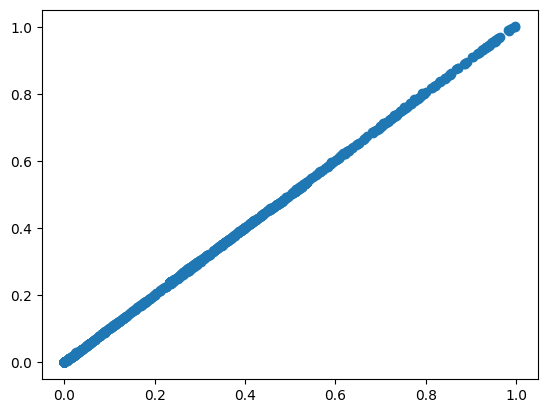

In [20]:
plt.scatter(y_x_denorm.cpu().numpy(), x_hat_denorm.detach().cpu().numpy())

In [24]:
from torch_geometric.data import Batch

def print_integrality_predictions(data_obj_list, data_feas_list, indices, description):
    print(f"--- {description} Solutions Integrality Predictions ---")
    model.eval()
    for i in indices:
        # Wrap single Data objects into a batch of size 1
        data_obj_batch = Batch.from_data_list([data_obj_list[i]]).to(device)
        data_feas_batch = Batch.from_data_list([data_feas_list[i]]).to(device)

        with torch.no_grad():
            x_hat, predicted_cost, predicted_constraints, predicted_integrality = model(data_obj_batch, data_feas_batch)

        # Now data_obj_batch and data_feas_batch have the .batch attribute
        # Extract ground truth integrality
        y_integrality = data_obj_batch.y_integrality.to(device)
        binary_mask = data_obj_batch.binary_mask[data_obj_batch.variable_mask].cpu().numpy()

        predicted_integrality_cpu = predicted_integrality.cpu().numpy()
        y_integrality_cpu = y_integrality.cpu().numpy()

        print(f"Solution index: {i}")
        print("Binary Variables (Indices):", np.where(binary_mask)[0])
        print("Predicted Integrality:", predicted_integrality_cpu)
        print("True Integrality:     ", y_integrality_cpu)
        print("------\n")

# Example usage:
feasible_indices = [0, 1, 2]  # Indices for feasible solutions in the test set
infeasible_nonintegral_indices = [len(test_data_obj)-3, len(test_data_obj)-2, len(test_data_obj)-1]

print_integrality_predictions(test_data_obj, test_data_feas, feasible_indices, "Feasible")
print_integrality_predictions(test_data_obj, test_data_feas, infeasible_nonintegral_indices, "Infeasible Non-Integral")


--- Feasible Solutions Integrality Predictions ---
Solution index: 0
Binary Variables (Indices): [30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53
 54 55 56 57 58 59]
Predicted Integrality: [3.5721666e-07 9.4408238e-01 9.4408238e-01 9.9937314e-01 9.4408238e-01
 1.8875800e-08 9.4408238e-01 9.9937314e-01 9.4408238e-01 3.4109473e-01
 9.4408238e-01 1.3061387e-05 9.9937314e-01 9.9937314e-01 1.7971946e-04
 9.9937314e-01 1.5641532e-04 1.5215267e-04 1.3687973e-07 1.1173832e-03
 1.5198921e-06 9.9937314e-01 1.9372342e-04 9.9937314e-01 1.7516238e-04
 9.4408238e-01 2.5660008e-06 2.1339265e-06 2.3325764e-07 7.8876526e-04]
True Integrality:      [0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1.
 0. 1. 0. 0. 0. 0.]
------

Solution index: 1
Binary Variables (Indices): [30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53
 54 55 56 57 58 59]
Predicted Integrality: [5.2159921e-05 4.7803415e-08 1.8515316e-04 2.2456820e-08 1.2589870e-04
 4.

In [28]:
from torch_geometric.data import Batch

def is_infeasible_nonintegral(data_obj, data_feas, feasibility_tol=1e-4):
    # Check feasibility
    y_constraints = data_feas.y_constraints.cpu().numpy()
    infeasible = np.any(y_constraints > feasibility_tol)

    # Check integrality: if any binary var is non-integral => y_integrality=0 for that var
    y_int = data_obj.y_integrality.cpu().numpy()

    nonintegral = np.any(y_int == 0)  # If any binary variable is non-integral

    return infeasible and nonintegral

def is_feasible_integral(data_obj, data_feas, feasibility_tol=1e-4):
    # Feasible if all constraints are within tolerance
    y_constraints = data_feas.y_constraints.cpu().numpy()
    feasible = np.all(y_constraints <= feasibility_tol + 1e-9)  # some tolerance

    # Integral if all binary vars integral
    y_int = data_obj.y_integrality.cpu().numpy()
    integral = np.all(y_int == 1)

    return feasible and integral

def print_integrality_predictions(data_obj_list, data_feas_list, indices, description, model, device):
    print(f"--- {description} Solutions Integrality Predictions ---")
    model.eval()
    for i in indices:
        data_obj = data_obj_list[i]
        data_feas = data_feas_list[i]

        # Wrap single samples into a Batch
        data_obj_batch = Batch.from_data_list([data_obj]).to(device)
        data_feas_batch = Batch.from_data_list([data_feas]).to(device)

        with torch.no_grad():
            x_hat, predicted_cost, predicted_constraints, predicted_integrality = model(data_obj_batch, data_feas_batch)

        # Ground truth integrality
        y_integrality = data_obj_batch.y_integrality.to(device)
        # Binary mask for variables
        binary_mask = data_obj_batch.binary_mask[data_obj_batch.variable_mask].cpu().numpy()

        predicted_integrality_cpu = predicted_integrality.cpu().numpy()
        y_integrality_cpu = y_integrality.cpu().numpy()

        print(f"Solution index: {i}")
        print("Binary Variables (Indices):", np.where(binary_mask)[0])
        print("Predicted Integrality:", predicted_integrality_cpu)
        print("True Integrality:     ", y_integrality_cpu)
        print("------\n")

# Now let's pick some actual feasible and infeasible_nonintegral solutions from the test set
feasible_candidates = []
infeas_nonint_candidates = []

# We'll scan through the test set to find a few examples
for idx in range(len(test_dataset)):
    data_obj, data_feas = test_dataset[idx]

    if is_feasible_integral(data_obj, data_feas):
        feasible_candidates.append(idx)
    elif is_infeasible_nonintegral(data_obj, data_feas):
        
        infeas_nonint_candidates.append(idx)

    # Stop if we have enough examples
    if len(feasible_candidates) >= 3 and len(infeas_nonint_candidates) >= 3:
        break

# Print some feasible solution predictions
if feasible_candidates:
    print_integrality_predictions(test_data_obj, test_data_feas, feasible_candidates[:3], "Feasible", model, device)
else:
    print("No feasible integral examples found in test set.")

# Print some infeasible non-integral solution predictions
if infeas_nonint_candidates:
    print_integrality_predictions(test_data_obj, test_data_feas, infeas_nonint_candidates[:3], "Infeasible Non-Integral", model, device)
else:
    print("No infeasible non-integral examples found in test set.")


--- Feasible Solutions Integrality Predictions ---
Solution index: 11
Binary Variables (Indices): [30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53
 54 55 56 57 58 59]
Predicted Integrality: [0.99937314 0.99937314 0.99937314 0.99937314 0.99937314 0.99937314
 0.99937314 0.99937314 0.99937314 0.99937314 0.99937314 0.99937314
 0.99937314 0.99937314 0.99937314 0.99937314 0.99937314 0.99937314
 0.9440824  0.99937314 0.99937314 0.99937314 0.99937314 0.9440824
 0.99937314 0.99937314 0.99937314 0.99937314 0.99937314 0.99937314]
True Integrality:      [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]
------

Solution index: 15
Binary Variables (Indices): [30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53
 54 55 56 57 58 59]
Predicted Integrality: [0.99937314 0.99937314 0.99937314 0.99937314 0.99937314 0.99937314
 0.99937314 0.99937314 0.99937314 0.99937314 0.99937314 0.99937314
 0.99937314 0.99937314 0.99937

In [29]:
def evaluate_predictions(model, data_list_obj, data_list_feas):
    model.eval()
    actual_costs = []
    predicted_costs = []
    actual_constraints = []
    predicted_constraints_list = []

    # For integrality evaluation
    total_binary_vars = 0
    correct_integrality_preds = 0

    with torch.no_grad():
        for data_obj, data_feas in zip(data_list_obj, data_list_feas):
            data_obj, data_feas = data_obj.to(device), data_feas.to(device)

            # Ground truth solution
            y_x = data_obj.y_x * std_y_x + mean_y_x  # Denormalize x
            y_x_np = y_x.detach().cpu().numpy()  # (n_variables,)

            # Compute actual cost
            actual_cost = 0.5 * y_x_np.T @ Q @ y_x_np  # Quadratic form
            actual_costs.append(actual_cost)

            # Compute actual constraint violations
            inequality_violations = A @ y_x_np - b_vector
            equality_violations = E @ y_x_np - d_vector
            actual_constraint = np.concatenate((inequality_violations, equality_violations))
            actual_constraints.extend(actual_constraint)

            # Prepare batches
            data_obj_batch = Batch.from_data_list([data_obj]).to(device)
            data_feas_batch = Batch.from_data_list([data_feas]).to(device)

            # Forward pass
            x_hat, predicted_cost, predicted_constraints, predicted_integrality = model(data_obj_batch, data_feas_batch)

            # Denormalize predicted cost and constraints
            predicted_cost_denorm = (predicted_cost.item() * std_y_cost + mean_y_cost)
            predicted_constraints_denorm = (predicted_constraints * std_y_constraints + mean_y_constraints).detach().cpu().numpy()

            predicted_costs.append(predicted_cost_denorm)
            predicted_constraints_list.extend(predicted_constraints_denorm)

            # Evaluate integrality predictions
            # Extract ground truth integrality
            y_integrality = data_obj_batch.y_integrality.cpu().numpy()  # shape: [num_binary_vars_in_graph]
            predicted_integrality_cpu = predicted_integrality.cpu().numpy()

            # Binarize predicted integrality: 1 if p>0.5 else 0
            predicted_integrality_bin = (predicted_integrality_cpu > 0.5).astype(float)

            # Count correct integrality predictions
            correct_integrality_preds += np.sum(predicted_integrality_bin == y_integrality)
            total_binary_vars += len(y_integrality)

    # Compute correlations for cost and constraints
    cost_correlation = np.corrcoef(actual_costs, predicted_costs)[0, 1]
    constraint_correlation = np.corrcoef(np.array(actual_constraints), np.array(predicted_constraints_list))[0, 1]

    # Compute integrality accuracy
    integrality_accuracy = correct_integrality_preds / total_binary_vars if total_binary_vars > 0 else 0.0

    print(f"Cost Prediction Correlation: {cost_correlation}")
    print(f"Constraint Prediction Correlation: {constraint_correlation}")
    print(f"Integrality Prediction Accuracy: {integrality_accuracy * 100:.2f}%")


In [30]:
# Assuming you have test_data_obj and test_data_feas
evaluate_predictions(model, test_data_obj, test_data_feas)

Cost Prediction Correlation: 0.9994264150981651
Constraint Prediction Correlation: 0.8946393781570621
Integrality Prediction Accuracy: 99.45%


## LTO

In [31]:
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=joint_collate_fn)

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
from collections import defaultdict

def compute_mean_embeddings(train_loader):
    variable_sums = defaultdict(lambda: torch.zeros(model.encoder_obj.conv2.out_channels + model.encoder_cons.conv2.out_channels))
    variable_counts = defaultdict(int)
    constraint_sums = defaultdict(lambda: torch.zeros(model.encoder_cons.conv2.out_channels))
    constraint_counts = defaultdict(int)

    # Integrality accumulators
    integrality_sums = defaultdict(float)
    integrality_counts = defaultdict(int)

    for data_obj_batch, data_feas_batch in train_loader:
        with torch.no_grad():
            data_obj_batch, data_feas_batch = data_obj_batch.to(device), data_feas_batch.to(device)
            x_obj = model.encoder_obj(data_obj_batch)
            x_cons_var, x_cons_constraints = model.encoder_cons(data_feas_batch)

            x_obj_var = x_obj[data_obj_batch.variable_mask]
            x_var = torch.cat([x_obj_var, x_cons_var], dim=1)

            # Run full model to get integrality predictions
            x_hat, predicted_cost, predicted_constraints, predicted_integrality = model(data_obj_batch, data_feas_batch)

            # Move to CPU
            x_var_cpu = x_var.cpu()
            x_cons_constraints_cpu = x_cons_constraints.cpu()

            # Aggregate variable embeddings as PyTorch tensors (no .numpy() call)
            for idx in range(x_var_cpu.size(0)):
                variable_sums[idx] += x_var_cpu[idx]
                variable_counts[idx] += 1

            # Aggregate constraint embeddings
            for idx in range(x_cons_constraints_cpu.size(0)):
                constraint_sums[idx] += x_cons_constraints_cpu[idx]
                constraint_counts[idx] += 1

            # Aggregate integrality predictions for binary variables
            binary_mask = data_obj_batch.binary_mask[data_obj_batch.variable_mask].cpu().numpy()
            predicted_integrality_cpu = predicted_integrality.cpu().numpy()

            binary_var_indices = np.where(binary_mask)[0]
            for b_idx, var_idx in enumerate(binary_var_indices):
                integrality_sums[var_idx] += predicted_integrality_cpu[b_idx]
                integrality_counts[var_idx] += 1

    # Compute mean embeddings
    mean_x_var_list = [variable_sums[idx] / variable_counts[idx] for idx in sorted(variable_sums.keys())]
    mean_x_cons_constraints_list = [constraint_sums[idx] / constraint_counts[idx] for idx in sorted(constraint_sums.keys())]

    # Stack them into tensors
    mean_x_var_tensor = torch.stack(mean_x_var_list)
    mean_x_cons_constraints_tensor = torch.stack(mean_x_cons_constraints_list)

    # Compute mean integrality predictions
    mean_integrality = {}
    for var_idx in sorted(integrality_sums.keys()):
        mean_integrality[var_idx] = integrality_sums[var_idx] / integrality_counts[var_idx]

    return mean_x_var_tensor, mean_x_cons_constraints_tensor, mean_integrality

# Now call the function
mean_x_var_tensor, mean_x_cons_constraints_tensor, mean_integrality = compute_mean_embeddings(train_loader)


Iteration 1/1000, Total Loss: 289313.0625, Cost Loss: 3.6701, Constraint Loss: 12.7554, Integrality Loss: 1.6176, Positivity Loss: 0.0000
Iteration 100/1000, Total Loss: 47422.7070, Cost Loss: 0.3002, Constraint Loss: 0.0100, Integrality Loss: 0.4731, Positivity Loss: 0.0000
Iteration 200/1000, Total Loss: -322.0095, Cost Loss: 0.3021, Constraint Loss: 0.0337, Integrality Loss: -0.0141, Positivity Loss: 0.0000
Iteration 300/1000, Total Loss: -400.8761, Cost Loss: 0.3022, Constraint Loss: 0.0338, Integrality Loss: -0.0149, Positivity Loss: 0.0000
Iteration 400/1000, Total Loss: -400.9158, Cost Loss: 0.3022, Constraint Loss: 0.0338, Integrality Loss: -0.0149, Positivity Loss: 0.0000
Iteration 500/1000, Total Loss: 116349.6797, Cost Loss: 0.3469, Constraint Loss: 0.0099, Integrality Loss: 1.0204, Positivity Loss: 0.0001
Iteration 600/1000, Total Loss: 203134.9219, Cost Loss: 0.2983, Constraint Loss: 0.0071, Integrality Loss: 1.7598, Positivity Loss: 0.0003
Iteration 700/1000, Total Loss: 

In [149]:
import torch
import torch.nn as nn
import torch.optim as optim
from collections import defaultdict
import numpy as np
import gurobipy as gp
from gurobipy import GRB

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assume these are defined:
# model, Q, A, E, b_vector, d_vector, variable_types_tensor
# mean_x_var_tensor, mean_x_cons_constraints_tensor

# Hyperparameters
alpha = 10.0
beta = 0.1
gamma = 0.1
zeta = 10.0  # integrality penalty weight (reduced from before)
pos_weight = 100.0
num_iterations = 3000

Q_tensor = torch.tensor(Q, dtype=torch.float32, device=device)
A_tensor = torch.tensor(A, dtype=torch.float32, device=device)
b_tensor = torch.tensor(b_vector, dtype=torch.float32, device=device)
E_tensor = torch.tensor(E, dtype=torch.float32, device=device)
d_tensor = torch.tensor(d_vector, dtype=torch.float32, device=device)

binary_mask = (variable_types_tensor == 1).to(device)
continuous_mask = ~binary_mask

# Gumbel-Softmax temperature
temp = 0.1  # Try reducing this over time if needed

def sample_gumbel_like(x):
    # Sample gumbel noise
    # Ensure x has no zeros to avoid NaN in logs
    u = torch.rand_like(x)
    return -torch.log(-torch.log(u + 1e-10) + 1e-10)

def gumbel_sigmoid(p, temp):
    # Convert probability p to logits
    # logits = log(p/(1-p))
    logits = torch.log(p + 1e-10) - torch.log(1 - p + 1e-10)
    g = sample_gumbel_like(p)
    return torch.sigmoid((logits + g) / temp)

def gradient_optimization_run(initial_x_var, initial_x_cons_constraints):
    x_var = nn.Parameter(initial_x_var.detach().clone().to(device))
    x_cons_constraints = nn.Parameter(initial_x_cons_constraints.detach().clone().to(device))
    
    optimizer = optim.Adam([x_var, x_cons_constraints], lr=0.01)

    for iteration in range(num_iterations):
        optimizer.zero_grad()

        # Decode predictions (continuous approximations)
        x_hat_raw = model.decoder_x(x_var).squeeze()
        
        # Apply Gumbel-Softmax to binary variables
        x_bin_prob = torch.clamp(x_hat_raw[binary_mask], 1e-5, 1-1e-5)
        x_bin_gumbel = gumbel_sigmoid(x_bin_prob, temp)

        # For continuous variables, just use x_hat_raw directly
        x_cont = x_hat_raw[continuous_mask]

        # Reconstruct x_hat with gumbelized binary variables
        x_hat = torch.zeros_like(x_hat_raw)
        x_hat[binary_mask] = x_bin_gumbel
        x_hat[continuous_mask] = x_cont

        # Encourage integrality: we can still use (x*(1-x))^2 to push towards 0 or 1
        integrality_loss = ((x_bin_gumbel * (1 - x_bin_gumbel))**2).sum()

        # Positivity Loss (for binary variables): discourage negatives (shouldn't be needed after sigmoid)
        positivity_loss = torch.relu(-x_hat).pow(2).sum()

        # Cost loss
        cost_loss = 0.5 * x_hat @ Q_tensor @ x_hat

        # Constraint violations
        inequality_violations = A_tensor @ x_hat - b_tensor
        inequality_constraint_loss = torch.relu(inequality_violations).pow(2).sum()

        equality_violations = E_tensor @ x_hat - d_tensor
        equality_constraint_loss = equality_violations.pow(2).sum()

        constraint_loss = inequality_constraint_loss + 2 * equality_constraint_loss

        penalty_var = torch.norm(x_var - mean_x_var_tensor.to(device), p=2)**2
        penalty_cons = torch.norm(x_cons_constraints - mean_x_cons_constraints_tensor.to(device), p=2)**2

        total_loss = (cost_loss 
                      + alpha * constraint_loss 
                      + beta * penalty_var 
                      + gamma * penalty_cons
                      + zeta * integrality_loss
                      + pos_weight * positivity_loss)

        total_loss.backward()
        optimizer.step()

        if ((iteration + 1) % 100 == 0) or iteration == 0:
            print(f"Iteration {iteration + 1}/{num_iterations}, "
                  f"Total Loss: {total_loss.item():.4f}, "
                  f"Cost Loss: {cost_loss.item():.4f}, "
                  f"Constraint Loss: {constraint_loss.item():.4f}, "
                  f"Integrality Loss: {integrality_loss.item():.4f}, "
                  f"Positivity Loss: {positivity_loss.item():.4f}, "
                  f"Avg Binary Var: {x_bin_gumbel.mean().item():.4f}")

    # Return the optimized x_hat (sampling again at the end)
    with torch.no_grad():
        # Re-sample once more or just decode final x_hat
        x_hat_raw = model.decoder_x(x_var).squeeze()
        x_bin_prob = torch.clamp(x_hat_raw[binary_mask], 1e-5, 1-1e-5)
        x_bin_gumbel = gumbel_sigmoid(x_bin_prob, temp)
        x_cont = x_hat_raw[continuous_mask]

        x_final = torch.zeros_like(x_hat_raw)
        x_final[binary_mask] = x_bin_gumbel
        x_final[continuous_mask] = x_cont
        return x_final.cpu().numpy()

def solve_projection(A, b, E, d, x_hat, variable_types):
    """
    Solves the projection problem:
    min_x || x - x_hat ||_2^2
    s.t. A x <= b
         E x = d
         x_j in R or Z depending on variable_types
    """
    n = x_hat.shape[0]
    m_ineq = A.shape[0] if A is not None else 0
    m_eq = E.shape[0] if E is not None else 0

    model = gp.Model("projection")
    model.Params.LogToConsole = 0  # Turn off logging if desired

    x_vars = []
    for j in range(n):
        if variable_types[j] == 1:
            vtype = GRB.BINARY
        else:
            vtype = GRB.CONTINUOUS
        x_vars.append(model.addVar(vtype=vtype, name=f"x_{j}"))
    model.update()

    # Add inequality constraints: A x <= b
    if m_ineq > 0:
        for i in range(m_ineq):
            expr = gp.quicksum(A[i, j]*x_vars[j] for j in range(n))
            model.addConstr(expr <= b[i], name=f"ineq_{i}")

    # Add equality constraints: E x = d
    if m_eq > 0:
        for i in range(m_eq):
            expr = gp.quicksum(E[i, j]*x_vars[j] for j in range(n))
            model.addConstr(expr == d[i], name=f"eq_{i}")

    obj = gp.QuadExpr()
    for j in range(n):
        obj.add(x_vars[j]*x_vars[j], 1.0)
        obj.add(-2 * x_hat[j] * x_vars[j], 1.0)
    model.setObjective(obj, GRB.MINIMIZE)

    model.optimize()

    if model.status != GRB.OPTIMAL:
        print("No optimal solution found. Status:", model.status)
        return None, None

    x_opt = np.array([var.x for var in x_vars])
    obj_value = model.objVal + np.sum(x_hat**2)
    return x_opt, obj_value


#########################################
# Running the optimization from 10 different starting values
#########################################

num_starts = 25
solutions = []
projection_solutions = []

for i in range(num_starts):
    print(f"Starting run {i+1}/{num_starts}")
    perturbed_x_var = mean_x_var_tensor + 0.1 * torch.randn_like(mean_x_var_tensor)
    perturbed_x_cons = mean_x_cons_constraints_tensor + 0.1 * torch.randn_like(mean_x_cons_constraints_tensor)

    x_optimized = gradient_optimization_run(perturbed_x_var, perturbed_x_cons)
    optimized_solution = np.round(x_optimized, 3)

    # Evaluate actual cost and feasibility
    actual_cost = 0.5 * optimized_solution.T @ Q @ optimized_solution
    inequality_violations = A @ optimized_solution - b_vector
    equality_violations = E @ optimized_solution - d_vector
    is_feasible = np.all(inequality_violations <= 1e-3) and np.allclose(equality_violations, 0, atol=1e-4)

    print("\nContinuous Variables (first 30):", optimized_solution[:30])
    print("Binary/Integer Variables (remaining):", optimized_solution[30:])
    print(f"Optimized Cost: {actual_cost}")
    print(f"Feasible: {is_feasible}")
    print("Inequality Violations (should be <= 0):", inequality_violations)
    print("Equality Violations (should be close to 0):", equality_violations)

    # Solve the projection problem
    x_opt_proj, obj_val_proj = solve_projection(A, b_vector, E, d_vector, optimized_solution, variable_types_tensor)
    print("Projected solution:", np.round(x_opt_proj, 3))
    print("Projection Objective value:", obj_val_proj)

    solutions.append(optimized_solution)
    projection_solutions.append(x_opt_proj)

print("\nAll runs complete.")


Starting run 1/25
Iteration 1/3000, Total Loss: 231.7262, Cost Loss: 4.4309, Constraint Loss: 17.3043, Integrality Loss: 0.0032, Positivity Loss: 0.0000, Avg Binary Var: 0.0684
Iteration 100/3000, Total Loss: 10.9972, Cost Loss: 0.0065, Constraint Loss: 0.0250, Integrality Loss: 0.0000, Positivity Loss: 0.0000, Avg Binary Var: 0.1333
Iteration 200/3000, Total Loss: 6.6444, Cost Loss: -0.0371, Constraint Loss: 0.0039, Integrality Loss: 0.0000, Positivity Loss: 0.0001, Avg Binary Var: 0.1665
Iteration 300/3000, Total Loss: 7.0069, Cost Loss: -0.0366, Constraint Loss: 0.0042, Integrality Loss: 0.0000, Positivity Loss: 0.0001, Avg Binary Var: 0.1667
Iteration 400/3000, Total Loss: 6.5662, Cost Loss: -0.0456, Constraint Loss: 0.0010, Integrality Loss: 0.0030, Positivity Loss: 0.0002, Avg Binary Var: 0.1314
Iteration 500/3000, Total Loss: 6.2590, Cost Loss: -0.0142, Constraint Loss: 0.0195, Integrality Loss: 0.0613, Positivity Loss: 0.0000, Avg Binary Var: 0.0817
Iteration 600/3000, Total Lo

In [152]:
projected = []

for i in range(len(projection_solutions)):

    print(projection_solutions[i].T @ Q @ projection_solutions[i])

    projected.append(projection_solutions[i].T @ Q @ projection_solutions[i])

0.1338397270915549
0.01867235740487037
0.004543973569268459
0.08876149329617194
0.004570547079828793
0.004078537850301397
0.2152577033409095
0.004521638027038667
0.004504850025162002
0.1386145436534758
0.02637033895253179
0.3003346524856814
0.004536810547857764
0.03450343912297493
0.016041523061295145
0.005316993280464461
0.12708486939478178
0.045503665469985105
0.09582713491112015
0.03629149544850988
0.10149474911531496
0.017201524700387435
0.11000330167012792
0.0041048588057269395
0.026399163018038053


In [156]:
np.mean(projected)

np.float64(0.06273519565293519)

In [153]:
random_sols = []

for i in range(30):

    print(feasible_solutions[i].T @ Q @ feasible_solutions[i])

    random_sols.append(feasible_solutions[i].T @ Q @ feasible_solutions[i])

0.5186636193049586
0.7157708975243896
0.49213344929882136
0.8753039068485481
0.9477576714983407
0.012211350757721309
0.5408177774662047
0.00758093706489434
0.9596022920536481
0.7867790444212563
0.6367734705107952
0.9214436379944309
0.006075243184777736
0.007225632311167893
0.37263950922923417
0.8432042069898658
0.9627674083772737
0.005573218720424675
0.954180692607723
0.898522221157742
0.9524992113246662
0.004773727267767728
0.9482085542427131
0.8158846538865803
0.005427895819516281
0.9526839092728414
0.9417715410087029
0.004490512969705882
0.004597113256493507
0.0058631191694359245


In [155]:
np.mean(random_sols)

np.float64(0.5367075475180214)

In [146]:
(0.003875233981588879 - 0.0036681139267364556)/0.0036681139267364556

0.05646500053958228

In [138]:
optimal_solution = np.array(optimal_solution)
optimal_solution.T @ Q @ optimal_solution

np.float64(0.0036681139267364556)

In [139]:
optimal_solution

array([ 0.        ,  0.        ,  0.49055482,  0.        ,  0.        ,
        0.09207045,  0.        ,  0.        ,  0.06558349,  0.20634722,
        0.        ,  0.14544402,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.        , -0.        ,  1.        , -0.        , -0.        ,
        1.        ,  0.        ,  0.        ,  1.        ,  1.        ,
       -0.        ,  1.        , -0.        ,  0.        , -0.        ,
        0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ])

In [140]:
projection_solutions[-2]

array([0.        , 0.        , 0.20040007, 0.1993999 , 0.        ,
       0.1993999 , 0.        , 0.        , 0.20040007, 0.        ,
       0.        , 0.20040007, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.        , 1.        , 0.        ,
       1.        , 0.        , 0.        , 1.        , 0.        ,
       0.        , 1.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])